# Part 3: Exploring `scoresFull.csv` with `Spark` Map-Reduce    

In this section, we'll be using the `scoresFull.csv` data set and using `Spark` map-reduce to find the mean and standard deviation for the quarter stats variables for each value of season. Then we'll graphically display the results.  

In [1]:
#Import models
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.pandas as ps
spark = SparkSession.builder.master('local[*]').getOrCreate()

To split files by season to perform the MapReduce

In [2]:
#Split the data
list_rdd=[]
#Read csv file
df=pd.read_csv("scoresFull.csv")
#Split into many files by season
for i in range(2002,2015):
    list_rdd.append(df[df["season"]==i])
#Transfer RDD files
Season_Rdd=spark.sparkContext.parallelize(list_rdd)
#Check if it is RDD
type(Season_Rdd)

pyspark.rdd.RDD

Create mapreduce def to perform sum, count and sum of sqaure

In [3]:
#Create def for mean and variance computing
#Parameter is list of desired variables
def mean_std(var_l):
    #Create dict for mean and std
    mean_dic={}
    std_dic={}
    for i in var_l:
        #MapReduce for sum
        sum_total=Season_Rdd.map(lambda x: x[i].sum()).map(lambda x: (i,x)).reduceByKey(lambda x,y: x+y).collect()[0][1]
        #MapReduce for count
        count_total=Season_Rdd.map(lambda x: x[i].count()).map(lambda x: (i,x)).reduceByKey(lambda x,y: x+y).collect()[0][1]
        #MapReduce for sum of sqaure
        sum_sqt_total=Season_Rdd.flatMap(lambda x: x[i]).map(lambda x: (i,x**2)).reduceByKey(lambda x,y: x+y).collect()[0][1]
        mean_dic[i]=sum_total/count_total          
        std_dic[i]= ((sum_sqt_total-count_total*(sum_total/count_total)**2)/(count_total-1))**0.5
    return [mean_dic,std_dic]

Perform MapReduce to calculate mean and std

In [4]:
#Apply the list of variables to find mean and std
Report_Q=["AQ1", "HQ1","AQ2", "HQ2","AQ3", "HQ3","AQ4", "HQ4","AFinal","HFinal"]
Report_list=mean_std(Report_Q)
print("\nMean is:\n",Report_list[0],"\nSTD is:\n",Report_list[1])


Mean is:
 {'AQ1': 3.9248055315471047, 'HQ1': 4.828867761452031, 'AQ2': 6.241428983002017, 'HQ2': 7.105157015269374, 'AQ3': 4.38692019590896, 'HQ3': 4.791126476519735, 'AQ4': 5.890233362143475, 'HQ4': 6.322961682512244, 'AFinal': 20.55718813022184, 'HFinal': 23.17401325266494} 
STD is:
 {'AQ1': 4.490700421089053, 'HQ1': 4.726903424009663, 'AQ2': 5.221593452957312, 'HQ2': 5.702788076137263, 'AQ3': 4.6327168250024915, 'HQ3': 4.755144845943296, 'AQ4': 5.278775371882614, 'HQ4': 5.417310283450347, 'AFinal': 10.195585841440774, 'HFinal': 10.40595174402417}


Using the information above, we can produce a line graph displaying the means for each quarter variable across the seasons.

In [5]:
dfs=spark.read.load("scoresFull.csv",format='csv',sep=",",inferSchema='true',header='true')
mean=dfs[['season','AQ1','AQ2','AQ3','AQ4','HQ1','HQ2','HQ3','HQ4']].groupby('season').avg().toPandas().sort_values(by = ["season"])

Text(0.5, 1.0, 'Means for Quarter Variables Across Season')

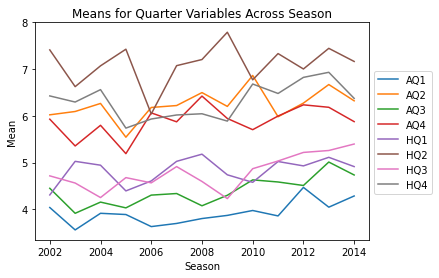

In [6]:
plt.plot(mean.season, mean["avg(AQ1)"], label = "AQ1")
plt.plot(mean.season, mean["avg(AQ2)"], label = "AQ2")
plt.plot(mean.season, mean["avg(AQ3)"], label = "AQ3")
plt.plot(mean.season, mean["avg(AQ4)"], label = "AQ4")
plt.plot(mean.season, mean["avg(HQ1)"], label = "HQ1")
plt.plot(mean.season, mean["avg(HQ2)"], label = "HQ2")
plt.plot(mean.season, mean["avg(HQ3)"], label = "HQ3")
plt.plot(mean.season, mean["avg(HQ4)"], label = "HQ4")

plt.legend(bbox_to_anchor = (1, 0.8))
plt.xlabel("Season")
plt.ylabel("Mean")
plt.title("Means for Quarter Variables Across Season")

The lines in the graph above appear to trend slightly upward in general, and are divided into two groups. The group with the highest mean values includes **HQ2**, **AQ2**, **HQ4**, and **AQ4**. The second group has generally lower means and includes **HQ1**, **HQ3**, **AQ3**, and **AQ1**. It appears that the means for Q2 and Q4 were higher than the means for Q1 and Q3.  